In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')


In [2]:
import os
import array

import pandas
import numpy

import plotly.express
import librosa
from matplotlib import pyplot as plt

In [3]:
combined_path = '../combined2.parquet'
samplerate = 104
acc_re = pandas.read_parquet(combined_path)

acc_re

,time,gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z,filename
0,2024-09-20 00:02:32.000000000,-0.025391,0.009461,0.024537,0.708396,0.388684,0.253914,0000-00-00T000232_brushing.npy
1,2024-09-20 00:02:32.009615385,0.004883,0.036683,0.058107,0.630879,0.333384,0.236091,0000-00-00T000232_brushing.npy
2,2024-09-20 00:02:32.019230769,0.032044,0.043031,0.091311,0.544084,0.290902,0.242683,0000-00-00T000232_brushing.npy
3,2024-09-20 00:02:32.028846154,0.050783,0.032838,0.115421,0.445936,0.244514,0.274545,0000-00-00T000232_brushing.npy
4,2024-09-20 00:02:32.038461538,0.063173,0.028443,0.127934,0.346446,0.195563,0.306772,0000-00-00T000232_brushing.npy
...,...,...,...,...,...,...,...,...
2075,2024-09-20 00:03:10.951923077,0.001404,-0.004517,-0.000977,0.009949,-0.075503,0.504837,0000-00-00T000251_brushing.npy
2076,2024-09-20 00:03:10.961538462,0.001221,-0.004517,-0.000977,0.010620,-0.075686,0.504532,0000-00-00T000251_brushing.npy
2077,2024-09-20 00:03:10.971153846,0.001221,-0.004456,-0.000916,0.010315,-0.075503,0.504288,0000-00-00T000251_brushing.npy
2078,2024-09-20 00:03:10.980769231,0.001221,-0.004578,-0.000793,0.010376,-0.075137,0.504471,0000-00-00T000251_brushing.npy


In [10]:
def make_spectrogram(df, sr=50, hop_length=16, columns=None):
    if columns is None:
        columns = ['acc_x', 'acc_y', 'acc_z']
    df = df.sort_values('time')
    df = df.dropna(subset=columns)
    
    n_fft = 4*hop_length

    # Make combined XYZ spectrogram, concat on frequency axis
    ss = []
    for c in columns:
        v = df[c].values
        S = librosa.stft(v, n_fft=n_fft, hop_length=hop_length)
        S = numpy.abs(S)
        S = librosa.amplitude_to_db(S)
        #S = S[1:,:] # drop DC
        ss.append(S)

    o = numpy.concatenate(ss)
    return o

mm = acc_re
specs = mm.groupby('filename').apply(make_spectrogram, sr=samplerate, hop_length=64, include_groups=False).to_frame().rename(columns={0:'spectrogram'})
specs;


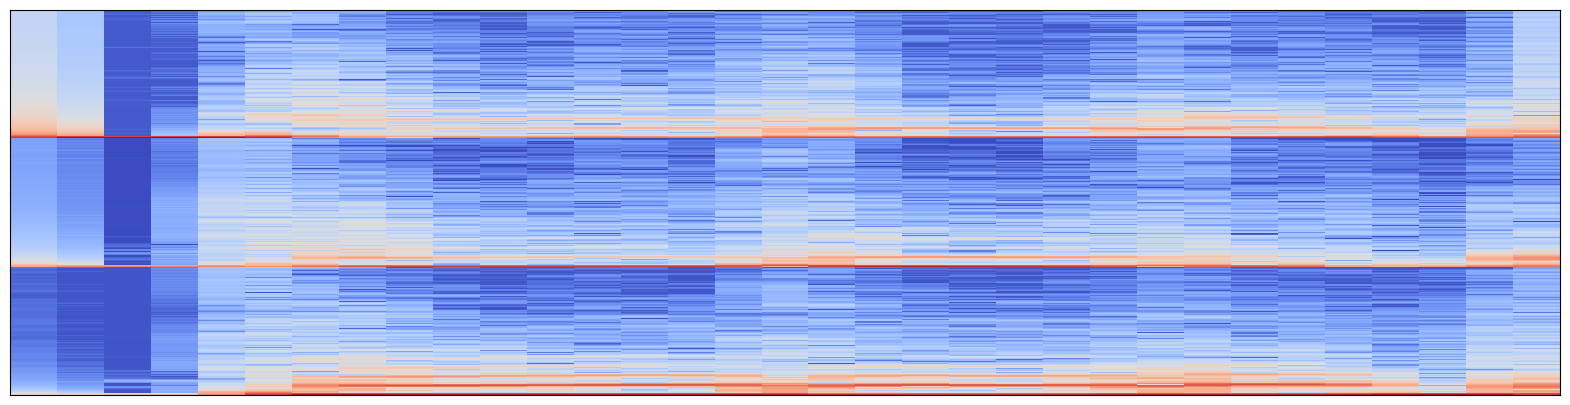

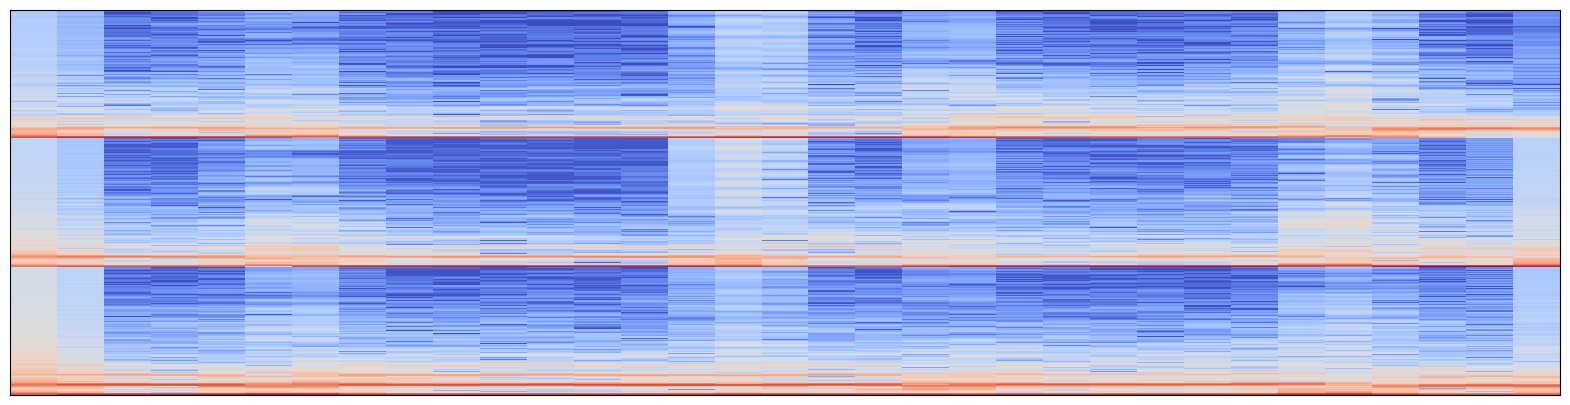

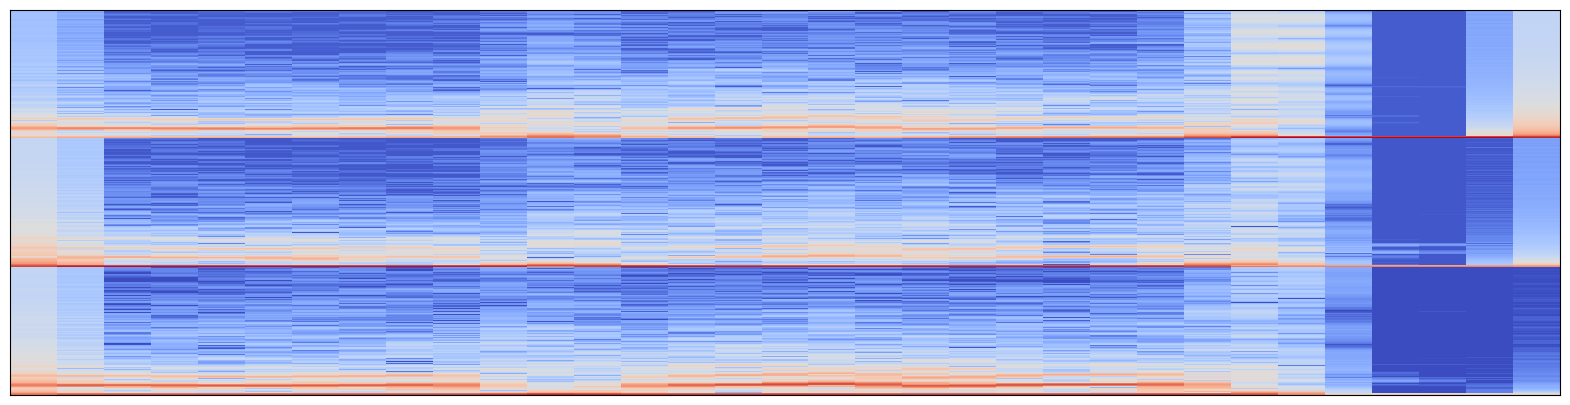

In [11]:

for filename, spec in specs.iterrows():
    #print(filename)
    fig, ax = plt.subplots(1, figsize=(20, 5))
    S = spec.spectrogram
    N = numpy.quantile(S, q=0.10, axis=1, keepdims=True)
    #S = S - N
    #print(S.shape, N.shape)
    librosa.display.specshow(ax=ax, data=S)


In [12]:
def to_spectrum(S):
    s = numpy.mean(S, axis=1)
    o = pandas.Series(s, index=numpy.arange(len(s)))
    return o

def compute_spectrums(df, sr, metric='motion', axes=['x', 'y', 'z']):
    dfs = []    
    
    for axis in axes:
        c = f'{metric}_{axis}'

        hop_length = 64
        freqs = librosa.fft_frequencies(n_fft=4*hop_length, sr=samplerate)
    
        specs = df.groupby('filename').apply(make_spectrogram, hop_length=hop_length, include_groups=False, columns=[c]).to_frame().rename(columns={0:'spectrogram'})
        ss = specs.spectrogram.apply(to_spectrum)
        print(ss.shape, len(freqs))
        ss.columns = freqs

        # Normalize
        N = numpy.mean(ss.values, axis=1, keepdims=1)
        ss = pandas.DataFrame(ss-N, columns=ss.columns, index=ss.index)
        #print(ss.shape, N.shape)
        #print(ss.head())
        
        sf = pandas.melt(ss.reset_index(), id_vars='filename', var_name='frequency')
        sf['axis'] = axis
        
        dfs.append(sf)

    out = pandas.concat(dfs)
    return out

mm = mm.rename(columns={'x': 'acc_x', 'y': 'acc_y', 'z': 'acc_z'})
spectrums = compute_spectrums(mm, sr=samplerate, metric='acc')
#spectrums


(3, 129) 129
(3, 129) 129
(3, 129) 129


In [32]:

def plot_spectrums(spectrums):
    
    import seaborn
    g = seaborn.relplot(spectrums,
        kind='line',
        #row='axis',
        hue='axis',
        x='frequency',
        y='value',
        height=5,
        aspect=2.0,
        #title='Toothbrushing spectrum - Hussain 2021 dataset',
        #labels={
        #    "frequency": "Frequency (Hz)",
        #    "value": "Energy (dB)",
        # },
    )
    from matplotlib.ticker import AutoMinorLocator, MultipleLocator
    
    for ax in g.axes.flatten():
        ax.grid(which='minor')
        ax.grid(which='major')
        ax.xaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_minor_locator(MultipleLocator(1))

    return g.figure

plot_spectrums(spectrums);

NameError: name 'spectrums' is not defined

In [91]:
import numpy as np
from scipy.signal import iirfilter, sosfreqz, sosfiltfilt
import plotly.graph_objects as go

def create_lowpass_filters(sample_rate=50, cutoff=0.5, order=4):
    nyquist = sample_rate / 2
    normalized_cutoff = cutoff / nyquist
    
    butterworth = iirfilter(order, normalized_cutoff, 
                           btype='lowpass', ftype='butter', output='sos')
    
    elliptic = iirfilter(order, normalized_cutoff, btype='lowpass', ftype='ellip',
                        rp=1.0, rs=40, output='sos')
    
    return {
        'Butterworth': butterworth,
        'Elliptic': elliptic,
        'sample_rate': sample_rate,
        'cutoff': cutoff
    }

def plot_filter_responses(filters_dict):
    fig = go.Figure()
    
    sample_rate = filters_dict['sample_rate']
    cutoff = filters_dict['cutoff']
    nyquist = sample_rate / 2
    
    freq = np.logspace(-2, np.log10(nyquist), 1000)
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for i, (name, sos) in enumerate(filters_dict.items()):
        if name in ['sample_rate', 'cutoff']:
            continue
            
        w, h = sosfreqz(sos, worN=freq, fs=sample_rate)
        mag_db = 20 * np.log10(np.abs(h))

        #print(w)
        fig.add_trace(go.Scatter(
            x=w, y=mag_db, 
            name=name,
            line=dict(color=colors[i % len(colors)], width=2)
        ))
    
    fig.add_vline(x=cutoff, line_dash="dash", line_color="green",
                  annotation_text=f"Cutoff: {cutoff} Hz")
    fig.add_hline(y=-3, line_dash="dot", line_color="gray", 
                  annotation_text="-3dB")

    fig.update_yaxes(
        range=[-80, 5],
        dtick=10,        # tick spacing
        autorange=False  # disable auto-ranging
    )
    
    fig.update_layout(
        title=f'Low-Pass Filter Comparison (Fs={sample_rate}Hz, Fc={cutoff}Hz)',
        xaxis_title="Frequency (Hz)",
        yaxis_title="Magnitude (dB)",
        xaxis_type="log",
        template='plotly_white'
    )
    
    return fig

filters = create_lowpass_filters(sample_rate=104, cutoff=1.0, order=3)
fig = plot_filter_responses(filters)
fig.add_vline(x=2.0, line_dash="dash", line_color="yellow")
fig.add_hline(y=-40.0, line_dash="dash", line_color="yellow")
fig.add_hline(y=-60.0, line_dash="dash", line_color="green")
fig.write_html('plot.html')


      gravity_x  gravity_y  gravity_z
0      0.033574   0.018092   0.011983
1      0.032634   0.017596   0.012210
2      0.031702   0.017103   0.012435
3      0.030780   0.016616   0.012658
4      0.029869   0.016134   0.012878
...         ...        ...        ...
2075   0.000423  -0.003109   0.025091
2076   0.000423  -0.003109   0.025091
2077   0.000423  -0.003109   0.025091
2078   0.000423  -0.003109   0.025091
2079   0.000423  -0.003109   0.025091

[6240 rows x 3 columns]
(3, 129) 129
(3, 129) 129
(3, 129) 129


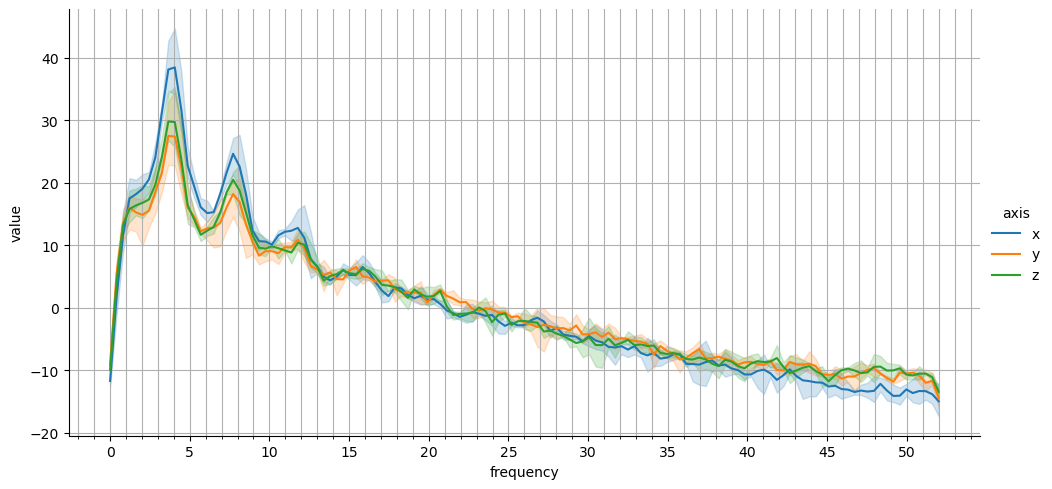

In [104]:

from software.features.featureutils import rms
from software.features.orientation import apply_lowpass

#lowpass = filters['Elliptic']
lowpass = filters['Butterworth']
sep = apply_lowpass(mm, lowpass=lowpass)

#del spectrums
s = compute_spectrums(sep, sr=samplerate, metric='linear_acc')
plot_spectrums(s);

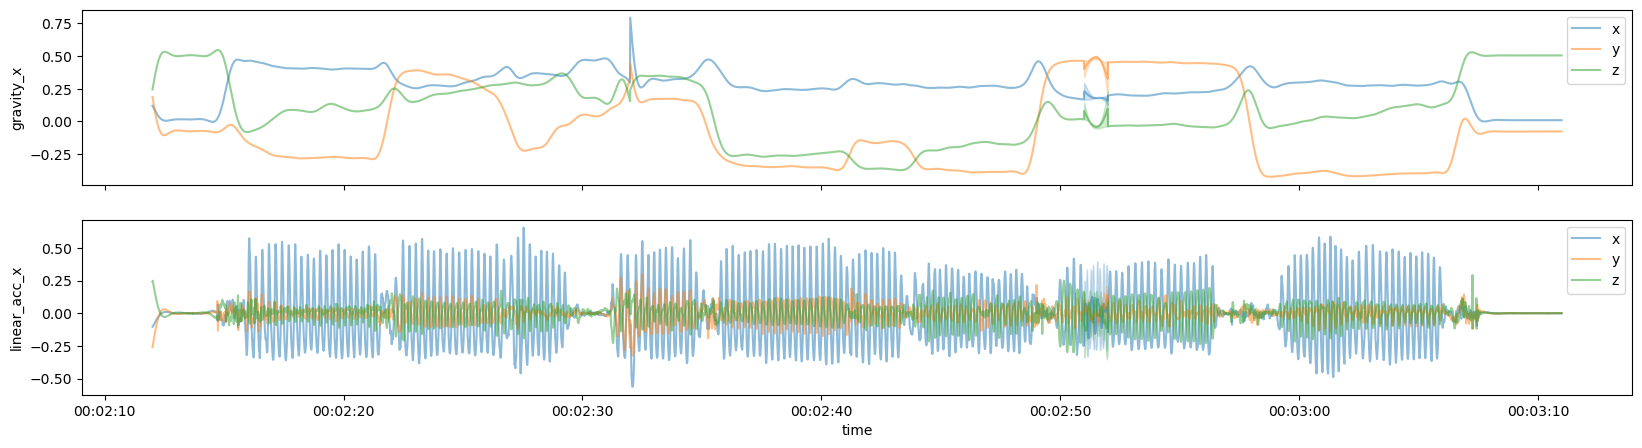

In [105]:

fig, axs = plt.subplots(2, figsize=(20, 5), sharex=True)
for axis in ['x', 'y', 'z']:
    seaborn.lineplot(sep, ax=axs[0], x='time', y=f'gravity_{axis}', legend=True, label=axis, alpha=0.5)
    seaborn.lineplot(sep, ax=axs[1], x='time', y=f'linear_acc_{axis}', legend=True, label=axis, alpha=0.5)
    axs[0].legend()
    axs[1].legend()


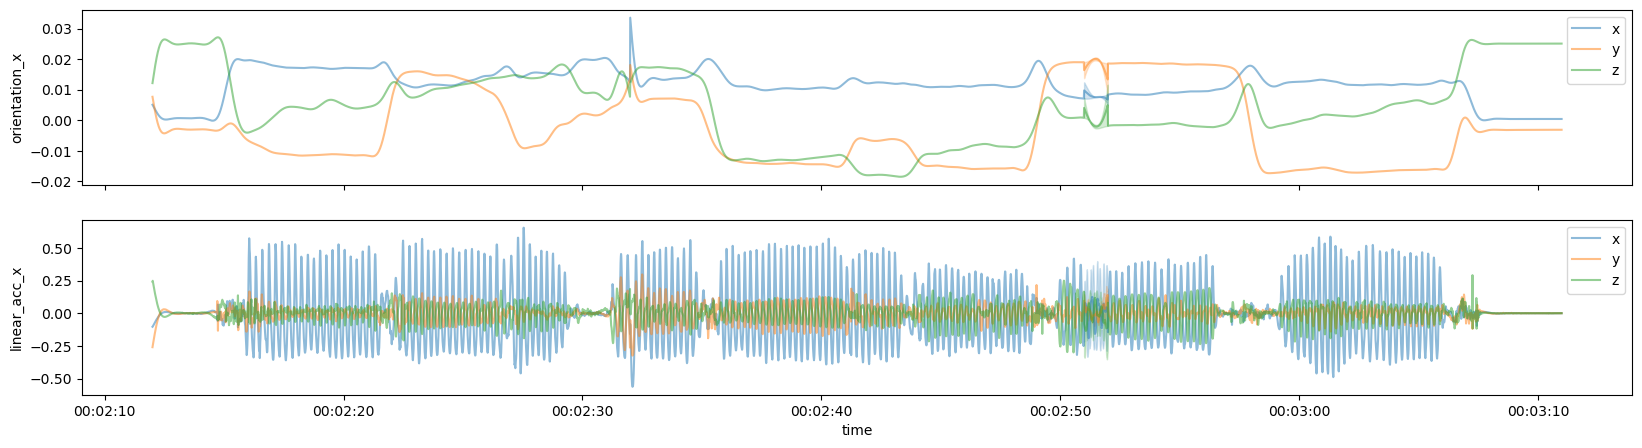

In [106]:
fig, axs = plt.subplots(2, figsize=(20, 5), sharex=True)
for axis in ['x', 'y', 'z']:
    seaborn.lineplot(sep, ax=axs[0], x='time', y=f'orientation_{axis}', legend=True, label=axis, alpha=0.5)
    seaborn.lineplot(sep, ax=axs[1], x='time', y=f'linear_acc_{axis}', legend=True, label=axis, alpha=0.5)
    axs[0].legend()
    axs[1].legend()

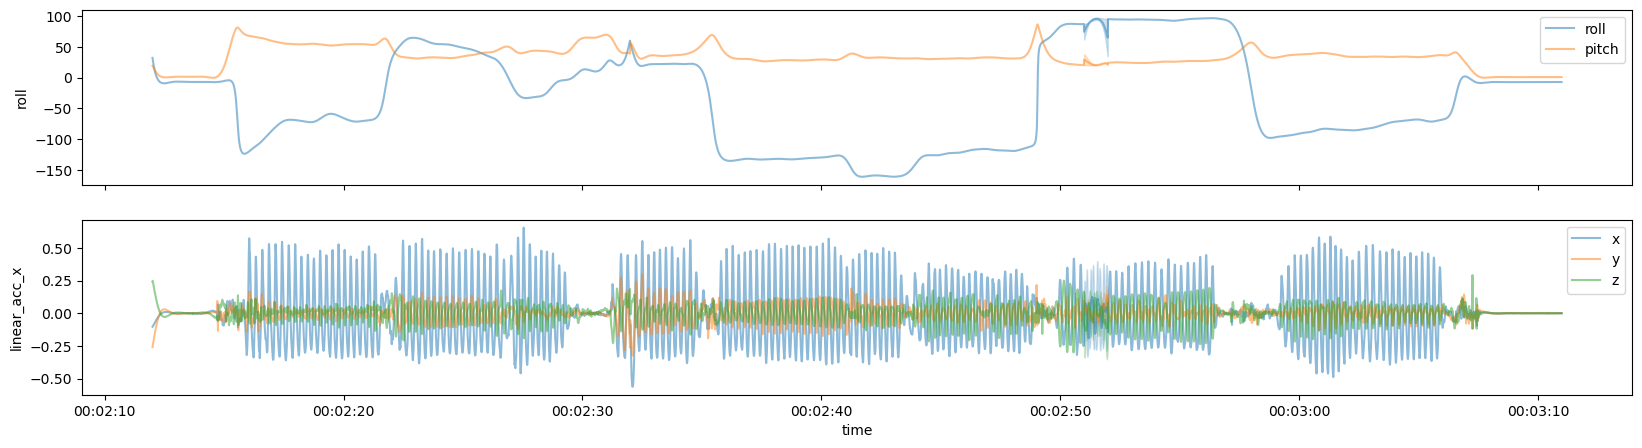

In [107]:
fig, axs = plt.subplots(2, figsize=(20, 5), sharex=True)
for col in ['roll', 'pitch']:
    seaborn.lineplot(sep, ax=axs[0], x='time', y=col, legend=True, label=col, alpha=0.5)
    
for axis in ['x', 'y', 'z']:
    #seaborn.lineplot(sep, ax=axs[0], x='time', y=f'orientation_{axis}', legend=True, label=axis, alpha=0.5)
    seaborn.lineplot(sep, ax=axs[1], x='time', y=f'linear_acc_{axis}', legend=True, label=axis, alpha=0.5)
    axs[0].legend()
    axs[1].legend()
    